# Fuck 3DGS Rasterization

## Fuck SH

In [1]:
import numpy as np

SH_C0 = 0.28209479177387814
SH_C1 = 0.4886025119029199
SH_C2 = [
    1.0925484305920792,
    -1.0925484305920792,
    0.31539156525252005,
    -1.0925484305920792,
    0.5462742152960396,
]
SH_C3 = [
    -0.5900435899266435,
    2.890611442640554,
    -0.4570457994644658,
    0.3731763325901154,
    -0.4570457994644658,
    1.445305721320277,
    -0.5900435899266435,
]

def computeColorFromSH(deg, pos, campos, sh):
    dir = pos - campos
    dir = dir / np.linalg.norm(dir)

    result = SH_C0 * sh[0]

    if deg > 0:
        x, y, z = dir
        result = result - SH_C1 * y * sh[1] + SH_C1 * z * sh[2] - SH_C1 * x * sh[3]

        if deg > 1:
            xx = x * x
            yy = y * y
            zz = z * z
            xy = x * y
            yz = y * z
            xz = x * z
            result = (
                result
                + SH_C2[0] * xy * sh[4]
                + SH_C2[1] * yz * sh[5]
                + SH_C2[2] * (2.0 * zz - xx - yy) * sh[6]
                + SH_C2[3] * xz * sh[7]
                + SH_C2[4] * (xx - yy) * sh[8]
            )

            if deg > 2:
                result = (
                    result
                    + SH_C3[0] * y * (3.0 * xx - yy) * sh[9]
                    + SH_C3[1] * xy * z * sh[10]
                    + SH_C3[2] * y * (4.0 * zz - xx - yy) * sh[11]
                    + SH_C3[3] * z * (2.0 * zz - 3.0 * xx - 3.0 * yy) * sh[12]
                    + SH_C3[4] * x * (4.0 * zz - xx - yy) * sh[13]
                    + SH_C3[5] * z * (xx - yy) * sh[14]
                    + SH_C3[6] * x * (xx - 3.0 * yy) * sh[15]
                )
    result += 0.5
    return np.clip(result, a_min=0, a_max=1)


## Fuck transform and projection

In [2]:
def getWorld2View2(R, t, translate=np.array([0.0, 0.0, 0.0]), scale=1.0):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R.transpose()
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center
    Rt = np.linalg.inv(C2W)
    return np.float32(Rt)

In [3]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = np.tan((fovY / 2))
    tanHalfFovX = np.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = np.zeros((4, 4))

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

In [4]:
# basic transformation
def transformPoint4x4(p, matrix):
    matrix = np.array(matrix).flatten(order="F")
    x, y, z = p
    transformed = np.array(
        [
            matrix[0] * x + matrix[4] * y + matrix[8] * z + matrix[12],
            matrix[1] * x + matrix[5] * y + matrix[9] * z + matrix[13],
            matrix[2] * x + matrix[6] * y + matrix[10] * z + matrix[14],
            matrix[3] * x + matrix[7] * y + matrix[11] * z + matrix[15],
        ]
    )
    return transformed


def transformPoint4x3(p, matrix):
    matrix = np.array(matrix).flatten(order="F")
    x, y, z = p
    transformed = np.array(
        [
            matrix[0] * x + matrix[4] * y + matrix[8] * z + matrix[12],
            matrix[1] * x + matrix[5] * y + matrix[9] * z + matrix[13],
            matrix[2] * x + matrix[6] * y + matrix[10] * z + matrix[14],
        ]
    )
    return transformed

## Fuck rasterization and culling

In [5]:
# culling
def ndc2Pix(v, S):
    return ((v + 1.0) * S - 1.0) * 0.5

def in_frustum(p_orig, viewmatrix):
    # bring point to screen space
    p_view = transformPoint4x3(p_orig, viewmatrix)

    if p_view[2] <= 0.2:
        return None
    return p_view

### 计算3D协方差
$$
\Sigma = RSS^\top R^\top
$$

In [6]:
def computeCov3D(scale, mod, rot):
    S = np.array(
        [[scale[0] * mod, 0, 0], [0, scale[1] * mod, 0], [0, 0, scale[2] * mod]]
    )
    R = rot
    M = np.dot(R, S)
    cov3D = np.dot(M, M.T)

    return cov3D

### 计算2D协方差
$$
\Sigma'=JW\Sigma W^\top J^\top
$$

In [7]:
def computeCov2D(mean, focal_x, focal_y, tan_fovx, tan_fovy, cov3D, viewmatrix):
    t = transformPoint4x3(mean, viewmatrix)

    limx = 1.3 * tan_fovx
    limy = 1.3 * tan_fovy
    txtz = t[0] / t[2]
    tytz = t[1] / t[2]
    t[0] = min(limx, max(-limx, txtz)) * t[2]
    t[1] = min(limy, max(-limy, tytz)) * t[2]

    J = np.array(
        [
            [focal_x / t[2], 0, -(focal_x * t[0]) / (t[2] * t[2])],
            [0, focal_y / t[2], -(focal_y * t[1]) / (t[2] * t[2])],
            [0, 0, 0],
        ]
    )
    W = viewmatrix[:3, :3]
    T = np.dot(J, W)

    cov = np.dot(T, cov3D)
    cov = np.dot(cov, T.T)

    # Apply low-pass filter
    # Every Gaussian should be at least one pixel wide/high
    # Discard 3rd row and column
    cov[0, 0] += 0.3
    cov[1, 1] += 0.3
    return [cov[0, 0], cov[0, 1], cov[1, 1]]

## Let's Raterize!

In [8]:
from tqdm import tqdm
from math import sqrt, ceil

class Rasterizer:
    def __init__(self) -> None:
        pass

    def forward(
        self,
        P,  # int, num of guassians
        D,  # int, degree of spherical harmonics
        M,  # int, num of sh base function
        background,  # color of background, default black
        width,  # int, width of output image
        height,  # int, height of output image
        means3D,  # ()center position of 3d gaussian
        shs,  # spherical harmonics coefficient
        colors_precomp,
        opacities,  # opacities
        scales,  # scale of 3d gaussians
        scale_modifier,  # default 1
        rotations,  # rotation of 3d gaussians
        cov3d_precomp,
        viewmatrix,  # matrix for view transformation
        projmatrix,  # *(4, 4), matrix for transformation, aka mvp
        cam_pos,  # position of camera
        tan_fovx,  # float, tan value of fovx
        tan_fovy,  # float, tan value of fovy
        prefiltered,
    ) -> None:

        focal_y = height / (2 * tan_fovy)  # focal of y axis
        focal_x = width / (2 * tan_fovx)

        # run preprocessing per-Gaussians
        # transformation, bounding, conversion of SHs to RGB
        print("Starting preprocess per 3d gaussian...")
        preprocessed = self.preprocess(
            P,
            D,
            M,
            means3D,
            scales,
            scale_modifier,
            rotations,
            opacities,
            shs,
            viewmatrix,
            projmatrix,
            cam_pos,
            width,
            height,
            focal_x,
            focal_y,
            tan_fovx,
            tan_fovy,
        )

        # produce [depth] key and corresponding guassian indices
        # sort indices by depth
        depths = preprocessed["depths"]
        point_list = np.argsort(depths)

        # render
        print("Starting render...")
        out_color = self.render(
            point_list,
            width,
            height,
            preprocessed["points_xy_image"],
            preprocessed["rgbs"],
            preprocessed["conic_opacity"],
            background,
        )
        return out_color

    def preprocess(
        self,
        P,
        D,
        M,
        orig_points,
        scales,
        scale_modifier,
        rotations,
        opacities,
        shs,
        viewmatrix,
        projmatrix,
        cam_pos,
        W,
        H,
        focal_x,
        focal_y,
        tan_fovx,
        tan_fovy,
    ):

        rgbs = []  # rgb colors of gaussians
        cov3Ds = []  # covariance of 3d gaussians
        depths = []  # depth of 3d gaussians after view&proj transformation
        radii = []  # radius of 2d gaussians
        conic_opacity = []  # covariance inverse of 2d gaussian and opacity
        points_xy_image = []  # mean of 2d guassians
        for idx in range(P):
            # make sure point in frustum
            p_orig = orig_points[idx]
            p_view = in_frustum(p_orig, viewmatrix)
            if p_view is None:
                continue
            depths.append(p_view[2])

            # transform point, from world to ndc
            # Notice, proj_matrix already processed as mvp matrix
            p_hom = transformPoint4x4(p_orig, projmatrix)
            p_w = 1 / (p_hom[3] + 0.0000001)
            p_proj = [p_hom[0] * p_w, p_hom[1] * p_w, p_hom[2] * p_w]

            # compute 3d covarance by scaling and rotation parameters
            scale = scales[idx]
            rotation = rotations[idx]
            cov3D = computeCov3D(scale, scale_modifier, rotation)
            cov3Ds.append(cov3D)

            # compute 2D screen-space covariance matrix
            # based on splatting, -> JW Sigma W^T J^T
            cov = computeCov2D(
                p_orig, focal_x, focal_y, tan_fovx, tan_fovy, cov3D, viewmatrix
            )

            # invert covarance(EWA splatting)
            det = cov[0] * cov[2] - cov[1] * cov[1]
            if det == 0:
                depths.pop()
                cov3Ds.pop()
                continue
            det_inv = 1 / det
            conic = [cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv]
            conic_opacity.append([conic[0], conic[1], conic[2], opacities[idx]])

            # compute radius, by finding eigenvalues of 2d covariance
            # transfrom point from NDC to Pixel
            mid = 0.5 * (cov[0] + cov[1])
            lambda1 = mid + sqrt(max(0.1, mid * mid - det))
            lambda2 = mid - sqrt(max(0.1, mid * mid - det))
            my_radius = ceil(3 * sqrt(max(lambda1, lambda2)))
            point_image = [ndc2Pix(p_proj[0], W), ndc2Pix(p_proj[1], H)]

            radii.append(my_radius)
            points_xy_image.append(point_image)

            # convert spherical harmonics coefficients to RGB color
            sh = shs[idx]
            result = computeColorFromSH(D, p_orig, cam_pos, sh)
            rgbs.append(result)

        return dict(
            rgbs=rgbs,
            cov3Ds=cov3Ds,
            depths=depths,
            radii=radii,
            conic_opacity=conic_opacity,
            points_xy_image=points_xy_image,
        )

    def render(
        self, point_list, W, H, points_xy_image, features, conic_opacity, bg_color
    ):

        out_color = np.zeros((H, W, 3))
        pbar = tqdm(range(H * W))

        # loop pixel
        for i in range(H):
            for j in range(W):
                pbar.update(1)
                pixf = [i, j]
                C = [0, 0, 0]

                # loop gaussian
                for idx in point_list:

                    # init helper variables, transmirrance
                    T = 1

                    # Resample using conic matrix
                    # (cf. "Surface Splatting" by Zwicker et al., 2001)
                    xy = points_xy_image[idx]  # center of 2d gaussian
                    d = [
                        xy[0] - pixf[0],
                        xy[1] - pixf[1],
                    ]  # distance from center of pixel
                    con_o = conic_opacity[idx]
                    power = (
                        -0.5 * (con_o[0] * d[0] * d[0] + con_o[2] * d[1] * d[1])
                        - con_o[1] * d[0] * d[1]
                    )
                    if power > 0:
                        continue

                    # Eq. (2) from 3D Gaussian splatting paper.
                    # Compute color
                    alpha = min(0.99, con_o[3] * np.exp(power))
                    if alpha < 1 / 255:
                        continue
                    test_T = T * (1 - alpha)
                    if test_T < 0.0001:
                        break

                    # Eq. (3) from 3D Gaussian splatting paper.
                    color = features[idx]
                    for ch in range(3):
                        C[ch] += color[ch] * alpha * T

                    T = test_T

                # get final color
                for ch in range(3):
                    out_color[j, i, ch] = C[ch] + T * bg_color[ch]

        return out_color

In [9]:
# set guassian
pts = np.array([[2, 0, -2], [0, 2, -2], [-2, 0, -2]])
n = len(pts)
shs = np.random.random((n, 16, 3))
opacities = np.ones((n, 1))
scales = np.ones((n, 3))
rotations = np.array([np.eye(3)] * n)

# set camera
cam_pos = np.array([0, 0, 5])
R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])
proj_param = {"znear": 0.01, "zfar": 100, "fovX": 45, "fovY": 45}
viewmatrix = getWorld2View2(R=R, t=cam_pos)
projmatrix = getProjectionMatrix(**proj_param)
projmatrix = np.dot(projmatrix, viewmatrix)
tanfovx = np.tan(proj_param["fovX"] * 0.5)
tanfovy = np.tan(proj_param["fovY"] * 0.5)

In [10]:
rasterizer = Rasterizer()
out_color = rasterizer.forward(
    P=len(pts),
    D=3,
    M=16,
    background=np.array([0, 0, 0]),
    width=700,
    height=700,
    means3D=pts,
    shs=shs,
    colors_precomp=None,
    opacities=opacities,
    scales=scales,
    scale_modifier=1,
    rotations=rotations,
    cov3d_precomp=None,
    viewmatrix=viewmatrix,
    projmatrix=projmatrix,
    cam_pos=cam_pos,
    tan_fovx=tanfovx,
    tan_fovy=tanfovy,
    prefiltered=None,
)

Starting preprocess per 3d gaussian...
Starting render...


100%|██████████| 490000/490000 [00:18<00:00, 26374.18it/s]


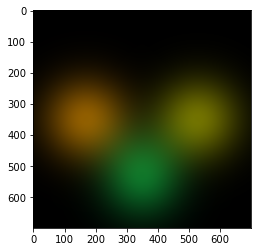

In [11]:
import matplotlib.pyplot as plt
plt.imshow(out_color)